In [1]:
from dask.distributed import Client, LocalCluster, wait
#from distributed import Client
import dask
import dask.array as da
import dask.dataframe as dd
import dask_ml.model_selection
import dask_ml.datasets
import dask_ml.cluster
from distributed import wait
import gcsfs
import toolz
import pandas as pd
import numpy as np
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.experimental.enable_hist_gradient_boosting
import sklearn.ensemble
import sklearn.linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
import joblib
%matplotlib inline

In [2]:
%load_ext blackcellmagic

In [3]:
client = Client()

In [4]:
client

Client Scheduler: tcp://127.0.0.1:35683 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 6 Memory: 16.73 GB


In [5]:
df = dd.read_parquet("gs://dask-nyc-taxi/yellowtrip.parquet",
                     engine="fastparquet",
                     storage_options={"token": "anon"})
df

,vendor_id,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount
npartitions=907,,,,,,,,,,,,,,
2014-01-01 00:00:00,category[unknown],datetime64[ns],int64,float64,float64,float64,category[unknown],float64,float64,category[unknown],float64,float64,float64,float64
2014-01-02 00:00:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 00:00:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 23:59:59,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
sdf = df.partitions[0].compute()

In [7]:
sdf = sdf.head(200_000)

sdf.head()

,vendor_id,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount
pickup_datetime,,,,,,,,,,,,,,
2014-01-01,VTS,2014-01-01 00:50:00,1,41.62,-73.871285,40.773962,nassau,-73.618775,41.200682,CSH,179.0,0.0,5.33,185.33
2014-01-01,VTS,2014-01-01 00:18:00,1,5.58,-73.961757,40.759820,standard,-73.978477,40.743305,CSH,17.0,0.0,0.00,18.00
2014-01-01,VTS,2014-01-01 00:28:00,3,6.20,-73.956543,40.778122,standard,-74.000382,40.718385,CRD,23.0,4.7,0.00,28.70
2014-01-01,VTS,2014-01-01 00:22:00,1,7.93,-73.979027,40.749187,standard,-73.899360,40.828842,CSH,25.0,0.0,0.00,26.00
2014-01-01,VTS,2014-01-01 00:03:00,6,1.05,-73.971300,40.792705,standard,-73.959910,40.800747,CSH,5.0,0.0,0.00,6.00


In [8]:
rides = pd.read_parquet("taxi-small.parquet", engine="fastparquet")
rides.head()

,vendor_id,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,tolls_amount,total_amount
pickup_datetime,,,,,,,,,,,,,,
2014-01-01,VTS,2014-01-01 00:50:00,1,41.62,-73.871285,40.773962,nassau,-73.618775,41.200682,CSH,179.0,0.0,5.33,185.33
2014-01-01,VTS,2014-01-01 00:18:00,1,5.58,-73.961757,40.759820,standard,-73.978477,40.743305,CSH,17.0,0.0,0.00,18.00
2014-01-01,VTS,2014-01-01 00:28:00,3,6.20,-73.956543,40.778122,standard,-74.000382,40.718385,CRD,23.0,4.7,0.00,28.70
2014-01-01,VTS,2014-01-01 00:22:00,1,7.93,-73.979027,40.749187,standard,-73.899360,40.828842,CSH,25.0,0.0,0.00,26.00
2014-01-01,VTS,2014-01-01 00:03:00,6,1.05,-73.971300,40.792705,standard,-73.959910,40.800747,CSH,5.0,0.0,0.00,6.00


In [9]:
features = [
    'passenger_count', 'trip_distance',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'fare_amount', 'tolls_amount', 'total_amount',
]

X = rides[features]
# Did they tip or not?
y = (rides['tip_amount'] > 0).astype(int)

In [10]:
pipeline100 = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1),
)

In [11]:
%time _ = pipeline100.fit(X, y)

CPU times: user 42.2 s, sys: 275 ms, total: 42.4 s
Wall time: 7.63 s


In [12]:
pipeline1000 = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.ensemble.RandomForestClassifier(
        n_estimators=1000, n_jobs=-1  # 100 -> 1,000
    )
)

In [13]:
%%time
with joblib.parallel_backend("dask"):
    pipeline1000.fit(X, y)

CPU times: user 12.6 s, sys: 1.55 s, total: 14.1 s
Wall time: 1min 19s


In [14]:
pipeline1000.steps[1]

('randomforestclassifier',
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=1000,
                        n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                        warm_start=False))

In [15]:
(pipeline1000.steps[1][1].feature_importances_)
#print(pipeline.feature_importances_)

array([0.00529703, 0.07116354, 0.02513728, 0.02564065, 0.03291379,
       0.0284482 , 0.32492725, 0.00621137, 0.4802609 ])

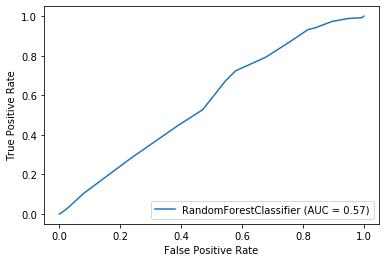

In [16]:
plot_roc_curve(pipeline100.steps[1][1], X, y)

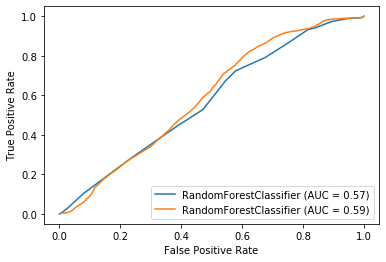

In [17]:
disp = plot_roc_curve(pipeline100.steps[1][1], X, y)
plot_roc_curve(pipeline1000.steps[1][1], X, y, ax=disp.ax_)

In [19]:
y_pred = pipeline1000.predict(X)

In [21]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    114762
           1       1.00      1.00      1.00     85238

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [18]:
pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(), sklearn.linear_model.LogisticRegression()
)

param_grid = dict(
    logisticregression__C=np.linspace(0.001, 10, 50),
    logisticregression__fit_intercept=[True, False],
    logisticregression__tol=[0.0001, 0.001],
)

search = dask_ml.model_selection.GridSearchCV(pipe, param_grid, cv=3)

In [19]:
import numpy as np

search.cv * np.prod([len(x) for x in param_grid.values()])

600

In [20]:
%time search.fit(X, y);

CPU times: user 15.7 s, sys: 1.33 s, total: 17.1 s
Wall time: 3min 1s


GridSearchCV(cache_cv=True, cv=3, error_score='raise',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                  

In [21]:
search.best_score_

0.98102

In [22]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,param_logisticregression__C,param_logisticregression__fit_intercept,param_logisticregression__tol
0,"{'logisticregression__C': 0.001, 'logisticregr...",0.769440,0.046109,0.042729,0.001641,0.796931,0.796811,0.729082,0.774275,0.031956,199,0.001,True,0.0001
1,"{'logisticregression__C': 0.001, 'logisticregr...",0.659780,0.063631,0.038741,0.006555,0.796931,0.796811,0.729082,0.774275,0.031956,199,0.001,True,0.001
2,"{'logisticregression__C': 0.001, 'logisticregr...",0.649098,0.049157,0.037161,0.010876,0.949480,0.940225,0.840713,0.910140,0.049237,197,0.001,False,0.0001
3,"{'logisticregression__C': 0.001, 'logisticregr...",0.602314,0.068362,0.043738,0.009544,0.949480,0.940225,0.840713,0.910140,0.049237,197,0.001,False,0.001
4,"{'logisticregression__C': 0.20506122448979594,...",1.305267,0.122441,0.038808,0.006102,0.995110,0.994915,0.929064,0.973030,0.031088,97,0.205061,True,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,"{'logisticregression__C': 9.795938775510205, '...",2.093183,0.466515,0.034640,0.009918,0.984955,0.985585,0.900249,0.956930,0.040080,101,9.79594,False,0.001
196,"{'logisticregression__C': 10.0, 'logisticregre...",1.695869,0.259022,0.030246,0.005412,0.997825,0.997615,0.947619,0.981020,0.023618,1,10,True,0.0001
197,"{'logisticregression__C': 10.0, 'logisticregre...",1.503341,0.238128,0.034341,0.006277,0.997825,0.997615,0.947619,0.981020,0.023618,1,10,True,0.001
198,"{'logisticregression__C': 10.0, 'logisticregre...",2.058200,0.495991,0.030967,0.014320,0.984955,0.985585,0.900264,0.956935,0.040073,99,10,False,0.0001


In [23]:
#n_samples = 100_000_000
#chunks = n_samples // 200
n_samples = 100_000
chunks = n_samples // 200

X, y = dask_ml.datasets.make_blobs(n_samples=n_samples, n_features=100,
                                   chunks=chunks)
display(X)

,Array,Chunk
Bytes,80.00 MB,400.00 kB
Shape,"(100000, 100)","(500, 100)"
Count,800 Tasks,200 Chunks
Type,float64,numpy.ndarray


In [25]:
X, y = client.persist([X, y])

In [26]:
kmeans = dask_ml.cluster.KMeans(max_iter=5, init_max_iter=5)

In [27]:
%time kmeans.fit(X)

CPU times: user 13.1 s, sys: 702 ms, total: 13.8 s
Wall time: 22.3 s


KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=5,
       max_iter=5, n_clusters=8, n_jobs=1, oversampling_factor=2,
       precompute_distances='auto', random_state=None, tol=0.0001)

In [28]:
kmeans.inertia_

992966.0454493783

In [33]:
# cpu and mem bound

Hyperband is a hyperparameter optimization algorithm works on larger-than-memory, distributed datasets. The implementation in dask-ml follows the usual scikit-learn interface for hyperparameter search.
Stop training a model if it is not performing well

In [5]:
from sklearn.datasets import make_circles
%matplotlib inline

X, y = make_circles(n_samples=10_000, random_state=0, noise=0.09)

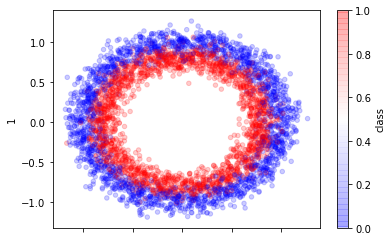

In [6]:
pd.DataFrame({0: X[:, 0], 1: X[:, 1], "class": y}).sample(4_000).plot.scatter(
    x=0, y=1, alpha=0.2, c="class", cmap="bwr"
)

In [7]:
X = StandardScaler().fit_transform(X)

In [8]:
X.shape

(10000, 2)

In [9]:
import dask
import dask.array as da
from distributed import wait
import numpy as np
from sklearn.utils import check_random_state

@dask.delayed(nout=2)
def clone(X, y, seed=None, noise=0.9, n_random=60, n_repeats=4):
    random_state = check_random_state(seed)
    
    # Add some noise
    X = X + random_state.normal(scale=noise, size=X.shape)
    
    # Add random features
    random_feats = random_state.normal(0, 1, size=(X.shape[0], n_repeats))
    X = np.hstack((X, random_feats))
    
    # Replicate multiple times
    X = np.repeat(X, n_repeats, axis=0)
    y = np.repeat(y, n_repeats, axis=0)
    
    return X, y

n_random=60
n_repeats=4
shape = n_repeats * X.shape[0], X.shape[1] + n_random
dX = dask.delayed(X)
dy = dask.delayed(y)

Xs, ys = zip(*[clone(dX, dy, seed=i,
                    n_random=n_random,
                    n_repeats=n_repeats)
               for i in range(1000)])

Xs = [da.from_delayed(x, dtype=X.dtype, shape=shape) for x in Xs]
ys = [da.from_delayed(x, dtype=y.dtype, shape=(shape[0],)) for x in ys]

X_big = da.concatenate(Xs)
y_big = da.concatenate(ys)

X, y = client.persist([X_big, y_big])
wait(X);

In [10]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
params = {
    "hidden_layer_sizes": [
        (24, ),
        (12, 12),
        (6, 6, 6, 6),
        (4, 4, 4, 4, 4, 4),
        (12, 6, 3, 3),
    ],
    "activation": ["relu", "logistic", "tanh"],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [16, 32, 64, 128, 256, 512],
}

In [11]:
import dask_ml.model_selection

search = dask_ml.model_selection.HyperbandSearchCV(
    model,
    params,
    max_iter=15,
    patience=True,
)

In [12]:
%time _ = search.fit(X, y, classes=[0, 1])

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:57968 remote=tcp://127.0.0.1:35683>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:45406 remote=tcp://127.0.0.1:36445>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:45412 remote=tcp://127.0.0.1:36445>


CPU times: user 24.9 s, sys: 948 ms, total: 25.8 s
Wall time: 37.9 s


In [13]:
search.best_params_

{'hidden_layer_sizes': (12, 12),
 'batch_size': 64,
 'alpha': 0.00035938136638046257,
 'activation': 'tanh'}

In [52]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score")

,std_score_time,mean_partial_fit_time,test_score,param_batch_size,params,bracket,param_alpha,partial_fit_calls,std_partial_fit_time,model_id,param_activation,rank_test_score,mean_score_time,param_hidden_layer_sizes
16,0.007988,0.215254,0.5139,16,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",0,0.000002,15,0.088474,bracket=0-2,relu,1,0.013226,"(12, 12)"
2,0.010589,0.172208,0.5052,64,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",2,0.000743,9,0.044804,bracket=2-2,tanh,1,0.019795,"(12, 6, 3, 3)"
13,0.008536,0.070093,0.5156,64,"{'hidden_layer_sizes': (24,), 'batch_size': 64...",1,0.000021,15,0.039157,bracket=1-4,relu,1,0.010636,"(24,)"
14,0.003774,0.189183,0.4928,32,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",0,0.000021,6,0.004974,bracket=0-0,logistic,2,0.010351,"(12, 6, 3, 3)"
6,0.000000,0.099812,0.5045,32,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",2,0.000010,1,0.000000,bracket=2-6,relu,2,0.002618,"(12, 12)"
9,0.012023,0.278597,0.5102,32,"{'hidden_layer_sizes': (6, 6, 6, 6), 'batch_si...",1,0.000012,5,0.157498,bracket=1-0,tanh,2,0.031827,"(6, 6, 6, 6)"
3,0.000000,0.190937,0.5031,32,"{'hidden_layer_sizes': (24,), 'batch_size': 32...",2,0.000003,1,0.000000,bracket=2-3,relu,3,0.002574,"(24,)"
12,0.004763,0.444607,0.5043,16,"{'hidden_layer_sizes': (6, 6, 6, 6), 'batch_si...",1,0.000005,5,0.105955,bracket=1-3,logistic,3,0.015697,"(6, 6, 6, 6)"
11,0.000747,0.172278,0.5043,128,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",1,0.000350,5,0.074852,bracket=1-2,logistic,3,0.004168,"(4, 4, 4, 4, 4, 4)"
15,0.015852,0.194939,0.4927,32,"{'hidden_layer_sizes': (24,), 'batch_size': 32...",0,0.000007,11,0.122545,bracket=0-1,logistic,3,0.017251,"(24,)"


In [53]:
pd.DataFrame(search.history_)

,model_id,params,partial_fit_calls,partial_fit_time,score,score_time,elapsed_wall_time,bracket
0,bracket=2-0,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",1,0.052497,0.5046,0.013251,12.322064,2
1,bracket=2-1,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",1,0.071040,0.4975,0.009256,12.322066,2
2,bracket=2-2,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",1,0.113965,0.5048,0.019725,12.322067,2
3,bracket=2-3,"{'hidden_layer_sizes': (24,), 'batch_size': 32...",1,0.190937,0.5031,0.002574,12.322067,2
4,bracket=2-4,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",1,0.060513,0.5046,0.018437,12.322067,2
5,bracket=2-5,"{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",1,0.041009,0.5019,0.006127,12.322068,2
6,bracket=2-6,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",1,0.099812,0.5045,0.002618,12.322068,2
7,bracket=2-7,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",1,0.082780,0.5005,0.019578,12.322069,2
8,bracket=2-8,"{'hidden_layer_sizes': (12, 12), 'batch_size':...",1,0.051679,0.5019,0.018559,12.322069,2
9,bracket=2-2,"{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",3,0.145859,0.5030,0.036026,12.616878,2
